## Final Project Submission

Please fill out:
* Student name: Zhiqiang Sun
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


# Business understanding
We have had the house selling records for the last few years. With these data, I want to build a model in which I can use the features in the data about the house to predict the price. In this case, we can guide both the seller and buyer to their business. The seller can use the model to predict the selling price of their house and if they need to do any renovation before selling their home. The buyer can have some suggestions about which kind of house they can afford based on their budget. 
To the details goal： 
1. polish the data which have no meaning or is null to the price.
2. remove the features which do not contribute to the house price. 
3. check if there are some high correlated features in which some of them can be removed.
4. build the linear regression model.
5. check how the features can contribute to the house change. 

In [2]:
# import all the necessary library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Loading the Data 
In the cell below, I load the house data into a dataframe and checked it's dimension and datatype.

In [3]:
# Your code here - remember to use markdown cells for comments as well!
df = pd.read_csv("data/kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


I need to steply remove and polish most of the columns which is not contribute to the price of house
1. The id is not related to the price
2. Split the date file to month and year.
3. Since the lat and long data is high related to the zipcode, I need to remove them.
4. Remodle the zip column with only the first three number
5. Remove the sqft_living15 and sqft_lot15 from columns.
6. Change the yr_built to the age of house at sold time
7. Change the yr_renovated to if the house is renovated and is the renovated within 10 and 30 years at sold.
8. Remove the 'sqft_living15', 'sqft_lot15'

In [4]:
df = df.drop(['id', 'lat', 'long'], axis  = 1)
df.zipcode = [int(x/10) for x in df.zipcode ]
month = []
year = []
for date in df.date:
    month.append(int(date.split('/')[0]))
    year.append(int (date.split('/')[2]))
df['month'] = month
df['year'] = (year)

df.fillna(value = 0, inplace=True)

df['is_renovated'] = [1  if x > 0 else 0 for x in df['yr_renovated']  ]
df['renovated_age'] = df['year'] - df['yr_renovated']
df['renovated_age2'] = [0 if x >1000 else x for x in df['renovated_age']]
df['renovated_10'] = [1 if (x <10) & (x >0)  else 0 for x in df['renovated_age2']]
df['renovated_30'] = [1 if (x <30) & (x >0) else 0 for x in df['renovated_age2']]
df['age_sold'] = df['year'] - df['yr_built']

#df['price'] = df['price']/(df['price'].max())
df['sqft_basement'] = [float(x) if x != '?' else 0.0 for x in df['sqft_basement']]

to_drop = ['date', 'sqft_living15', 'sqft_lot15' ,  'yr_renovated','yr_built', 'renovated_age', 'renovated_age2'  ] #, 
df_precessed = df.drop(to_drop, axis  = 1)
df_precessed = df_precessed[(df_precessed.bedrooms<33) & (df_precessed.age_sold >0)]
df_precessed.head()


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,month,year,is_renovated,renovated_10,renovated_30,age_sold
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,9817,10,2014,0,0,0,59
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,9812,12,2014,1,0,1,63
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,9802,2,2015,0,0,0,82
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,9813,12,2014,0,0,0,49
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,9807,2,2015,0,0,0,28


In [5]:
# I checked the number of unique value for each of the columns
df_precessed.nunique()

price            3446
bedrooms           11
bathrooms          29
sqft_living       993
sqft_lot         9643
floors              6
waterfront          2
view                5
condition           5
grade              11
sqft_above        904
sqft_basement     300
zipcode            19
month              12
year                2
is_renovated        2
renovated_10        2
renovated_30        2
age_sold          115
dtype: int64

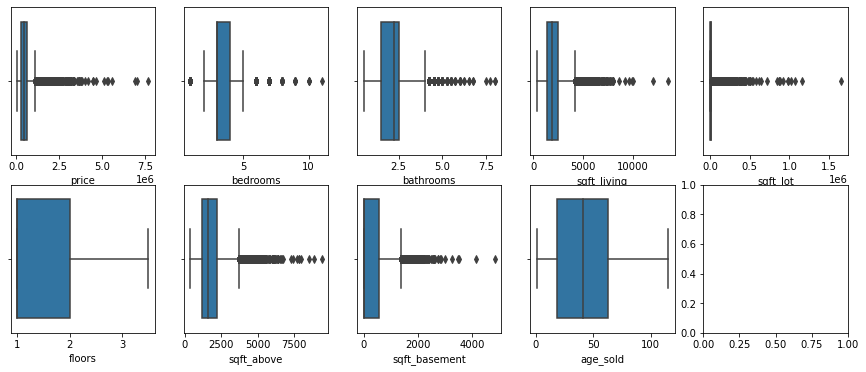

In [6]:
# I then drawed the distribution of each of the columns 
# which had more than 10 unique value to check if there is any outlier values.
fig, axs = plt.subplots(2,5, figsize = (15,6))
plt1 = sns.boxplot(df_precessed['price'], ax = axs[0,0])
plt2 = sns.boxplot(df_precessed['bedrooms'], ax = axs[0,1])
plt3 = sns.boxplot(df_precessed['bathrooms'], ax = axs[0,2])
plt4 = sns.boxplot(df_precessed['sqft_living'], ax = axs[0,3])
plt5 = sns.boxplot(df_precessed['sqft_lot'], ax = axs[0,4])
plt1 = sns.boxplot(df_precessed['floors'], ax = axs[1,0])
plt2 = sns.boxplot(df_precessed['sqft_above'], ax = axs[1,1])
plt3 = sns.boxplot(df_precessed['sqft_basement'], ax = axs[1,2])
plt4 = sns.boxplot(df_precessed['age_sold'], ax = axs[1,3])




In [7]:
#The above figures show that there are multipal columns contain some outlier data. 
#I then collected all the columns and remove them 
to_modify = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot','sqft_above','sqft_basement']
for col in to_modify:
    Q1 = df_precessed[col].quantile(0.25)
    Q3 = df_precessed[col].quantile(0.75)
    IQR = Q3 - Q1
    df_precessed = df_precessed[(df_precessed[col] >= Q1 - 1.5*IQR) & (df_precessed[col] <= Q3 + 1.5*IQR)]

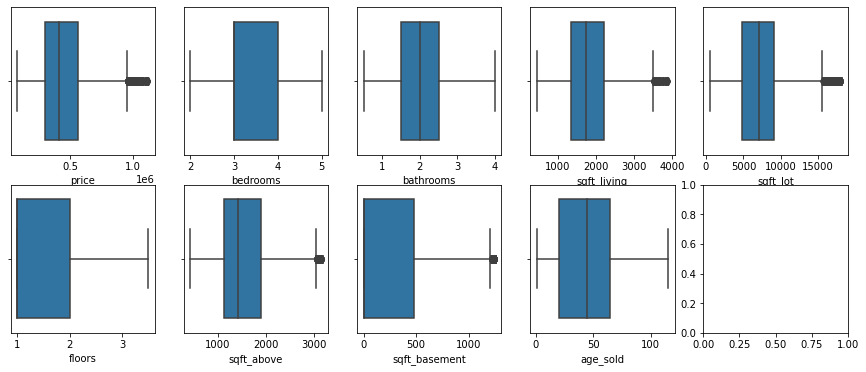

In [8]:
# check the data after modification
fig, axs = plt.subplots(2,5, figsize = (15,6))
plt1 = sns.boxplot(df_precessed['price'], ax = axs[0,0])
plt2 = sns.boxplot(df_precessed['bedrooms'], ax = axs[0,1])
plt3 = sns.boxplot(df_precessed['bathrooms'], ax = axs[0,2])
plt4 = sns.boxplot(df_precessed['sqft_living'], ax = axs[0,3])
plt5 = sns.boxplot(df_precessed['sqft_lot'], ax = axs[0,4])
plt1 = sns.boxplot(df_precessed['floors'], ax = axs[1,0])
plt2 = sns.boxplot(df_precessed['sqft_above'], ax = axs[1,1])
plt3 = sns.boxplot(df_precessed['sqft_basement'], ax = axs[1,2])
plt4 = sns.boxplot(df_precessed['age_sold'], ax = axs[1,3])


The data looks much better now with very few of outlier numbers.

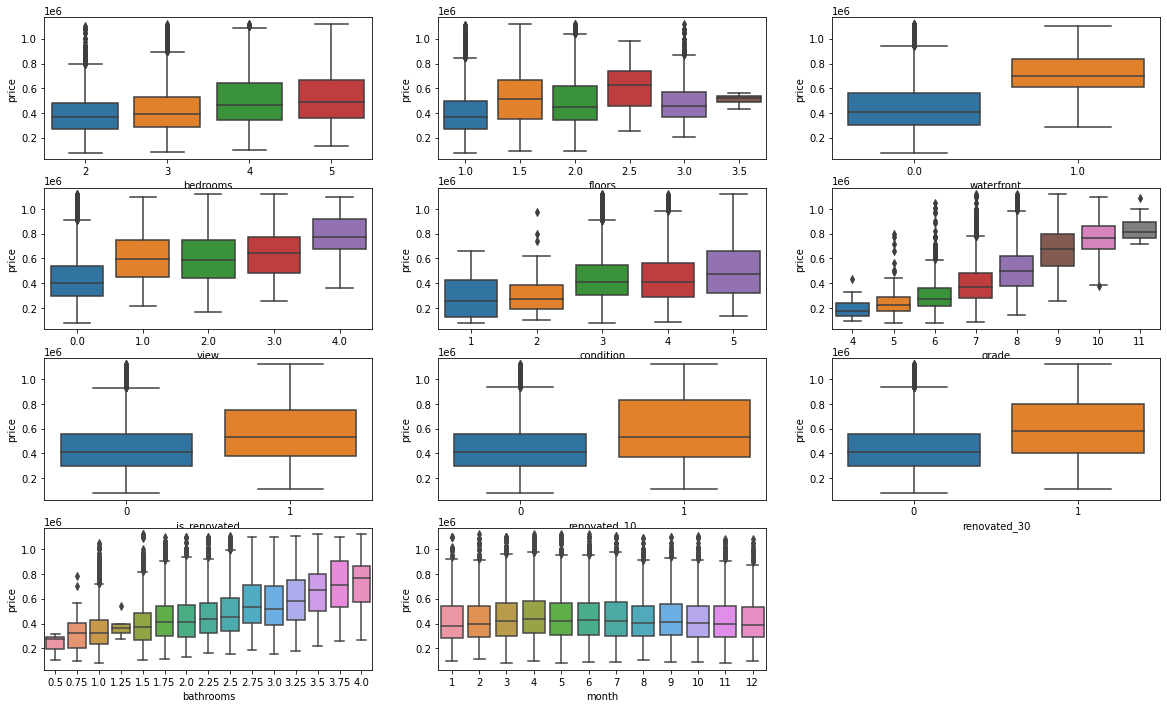

In [9]:
#  In order to check the relationship between the price with most of the columns with few unique numbers, 
# I plot their relations in seperate figures.
plt.figure(figsize=(20, 12))
plt.subplot(4,3,1)
sns.boxplot(x = 'bedrooms', y = 'price', data = df_precessed)
plt.subplot(4,3,2)
sns.boxplot(x = 'floors', y = 'price', data = df_precessed)
plt.subplot(4,3,3)
sns.boxplot(x = 'waterfront', y = 'price', data = df_precessed)
plt.subplot(4,3,4)
sns.boxplot(x = 'view', y = 'price', data = df_precessed)
plt.subplot(4,3,5)
sns.boxplot(x = 'condition', y = 'price', data = df_precessed)
plt.subplot(4,3,6)
sns.boxplot(x = 'grade', y = 'price', data = df_precessed)
plt.subplot(4,3,7)

sns.boxplot(x = 'is_renovated', y = 'price', data = df_precessed)
plt.subplot(4,3,8)
sns.boxplot(x = 'renovated_10', y = 'price', data = df_precessed)
plt.subplot(4,3,9)
sns.boxplot(x = 'renovated_30', y = 'price', data = df_precessed)
plt.subplot(4,3,10)
sns.boxplot(x = 'bathrooms', y = 'price', data = df_precessed)
plt.subplot(4,3,11)

sns.boxplot(x = 'month', y = 'price', data = df_precessed)
plt.show()

In [10]:
df_precessed.nunique()

price            2909
bedrooms            4
bathrooms          15
sqft_living       636
sqft_lot         6886
floors              6
waterfront          2
view                5
condition           5
grade               8
sqft_above        568
sqft_basement     160
zipcode            19
month              12
year                2
is_renovated        2
renovated_10        2
renovated_30        2
age_sold          115
dtype: int64

To avoid the high correlated features, I filtered the features and find the pair of features with correlation value between 0.7 and 1. 

In [11]:
# I tested the pairs of feature with correlation more than 0.75.
df = df_precessed.corr().abs().stack().reset_index().sort_values(0, ascending = False)
df['pairs'] = list(zip(df.level_0, df.level_1))
df.set_index(['pairs'], inplace = True)
df.drop(columns = ['level_0', "level_1"], inplace  = True)
df.columns = ['cc']
df.drop_duplicates(inplace = True)
df[(df.cc>.7) & (df.cc<1)]


,cc
pairs,
"(sqft_living, sqft_above)",0.814755
"(renovated_30, is_renovated)",0.808098
"(month, year)",0.786899


There are three pairs of features high related with each other. I need to remove at least one of the features in each pair. Comparing the last list, I decided to delete the columns sqft_above, renovated_30, year. 

In [12]:
to_drop = ['sqft_above', 'renovated_30',  'year' ]
df_precessed = df_precessed.drop(to_drop,axis  = 1 )

In [13]:
df_precessed.nunique()

price            2909
bedrooms            4
bathrooms          15
sqft_living       636
sqft_lot         6886
floors              6
waterfront          2
view                5
condition           5
grade               8
sqft_basement     160
zipcode            19
month              12
is_renovated        2
renovated_10        2
age_sold          115
dtype: int64

In [14]:
# Since there is some columns with only few number of unique values, I need to catalize the features.
to_cat = ['bedrooms','bathrooms', 'floors' ,'view','condition','grade','zipcode','month',]
df_cat = pd.DataFrame()
for col in to_cat:
    df_cat = pd.concat([df_cat, pd.get_dummies(df_precessed[col], prefix = col)], axis = 1)
df_cat.head()

,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#For the features with only 2 unique numbers, I did the drop_first when using dummies.
to_cat_2 = ['waterfront','is_renovated','renovated_10']
df_cat_2 = pd.DataFrame()
for col in to_cat_2:
    df_cat_2 = pd.concat([df_cat_2, pd.get_dummies(df_precessed[col], prefix = col, drop_first=True)], axis = 1)
df_cat_2.head()

,waterfront_1.0,is_renovated_1,renovated_10_1
0,0,0,0
1,0,1,0
2,0,0,0
3,0,0,0
4,0,0,0


In [16]:
# I then dropped the catalized columns and concat the new features.
df_precessed = df_precessed.drop(to_cat,axis  = 1 )
df_precessed = df_precessed.drop(to_cat_2,axis  = 1 )
df_precessed = pd.concat([df_precessed, df_cat, df_cat_2], axis = 1)
df_precessed.head()

,price,sqft_living,sqft_lot,sqft_basement,age_sold,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bathrooms_0.5,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,waterfront_1.0,is_renovated_1,renovated_10_1
0,221900.0,1180,5650,0.0,59,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,538000.0,2570,7242,400.0,63,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,180000.0,770,10000,0.0,82,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,1960,5000,910.0,49,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,510000.0,1680,8080,0.0,28,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Regression
Until now, I finished the polish of the all the features and then I will split the data to trainning and testing parts to do the fitting.  

In [17]:
#split the data to training and testing part
from sklearn.model_selection import train_test_split
y = df_precessed['price']
X = df_precessed.drop('price', axis  = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

12297 4099 12297 4099


# Build a Model with All Numeric Features 

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit

baseline_model = LinearRegression()


splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)
model = LinearRegression()

model_scores = cross_validate(
    estimator=model,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", model_scores["train_score"].mean())
print("Validation score:", model_scores["test_score"].mean())
print()


Current Model
Train score:      0.5897185649583689
Validation score: 0.5858295197121807



Our second model got better scores on the training data, and better scores on the validation data. However, I still want to continue to check how each feature work in general. Then I choose to check the coef value of the regression

#  Select the Best Combination of Features

Since there is a lot of features, I tried to check if there is some features can be removed.
Then, I tried to selecting Features with sklearn.feature_selection.

In [19]:
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
X_train_for_RFECV = StandardScaler().fit_transform(X_train)

model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train)

# Print the results
print("Was the column selected?")
for index, col in enumerate(X_train.columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected?
sqft_living: True
sqft_lot: True
sqft_basement: True
age_sold: True
bedrooms_2: True
bedrooms_3: True
bedrooms_4: True
bedrooms_5: True
bathrooms_0.5: True
bathrooms_0.75: True
bathrooms_1.0: True
bathrooms_1.25: True
bathrooms_1.5: True
bathrooms_1.75: True
bathrooms_2.0: True
bathrooms_2.25: True
bathrooms_2.5: True
bathrooms_2.75: True
bathrooms_3.0: True
bathrooms_3.25: True
bathrooms_3.5: True
bathrooms_3.75: True
bathrooms_4.0: True
floors_1.0: True
floors_1.5: True
floors_2.0: True
floors_2.5: True
floors_3.0: True
floors_3.5: True
view_0.0: True
view_1.0: True
view_2.0: True
view_3.0: True
view_4.0: True
condition_1: True
condition_2: True
condition_3: True
condition_4: True
condition_5: True
grade_4: True
grade_5: True
grade_6: True
grade_7: True
grade_8: True
grade_9: True
grade_10: True
grade_11: True
zipcode_9800: True
zipcode_9801: True
zipcode_9802: True
zipcode_9803: True
zipcode_9804: True
zipcode_9805: True
zipcode_9806: True
zipcode_9807: True

It looks like all the features is necessary.

In [20]:
import statsmodels.api as sm

sm.OLS(y_train, sm.add_constant(X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     240.7
Date:                Tue, 16 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:08:44   Log-Likelihood:            -1.6146e+05
No. Observations:               12297   AIC:                         3.231e+05
Df Residuals:                   12223   BIC:                         3.236e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.128e+05   8587.326     13.132      0.000    9.59e+04     1.3e+05
sqft_living      114.5637      3.919     29.231      0.000     106.881     122.246
sqft_lot          -2.8622      0.451     -6.341      0.000      -3.747      -1.977
sqft_basement    -14.8243      4.617     -3.211      0.001     -23.874      -5.774
age_sold        1828.3892     69.640     26.255      0.000    1691.884    1964.894
bedrooms_2      5.075e+04   3516.452     14.433      0.000    4.39e+04    5.76e+04
bedrooms_3      3.246e+04   2757.928     11.771      0.000    2.71e+04    3.79e+04
bedrooms_4      2.341e+04   3275.680      7.148      0.000     1.7e+04    2.98e+04
bedrooms_5      6143.6031   4910.263      1.251      0.211   -3481.289    1.58e+04
bathrooms_0.5  -8.656e+04   8.14e+04     -1.063      0.288   -2.46e+05    7.31e+04
bathrooms_0.75  3.978e+04   2.67e+04      1.492      0.136   -1.25e+04    9.21e+04
bathrooms_1.0  -1.834e+04   8827.386     -2.078      0.038   -3.56e+04   -1037.514
bathrooms_1.25 -1.292e+05   6.64e+04     -1.945      0.052   -2.59e+05    1008.060
bathrooms_1.5  -1.185e+04   8950.308     -1.324      0.185   -2.94e+04    5691.263
bathrooms_1.75   994.1981   8576.675      0.116      0.908   -1.58e+04    1.78e+04
bathrooms_2.0  -2495.5087   8743.921     -0.285      0.775   -1.96e+04    1.46e+04
bathrooms_2.25  1.156e+04   8746.531      1.322      0.186   -5582.882    2.87e+04
bathrooms_2.5   5801.8066   8491.165      0.683      0.494   -1.08e+04    2.24e+04
bathrooms_2.75  2.455e+04   9588.811      2.560      0.010    5756.367    4.33e+04
bathrooms_3.0   1.253e+04   1.04e+04      1.205      0.228   -7852.595    3.29e+04
bathrooms_3.25  4.406e+04   1.22e+04      3.606      0.000    2.01e+04     6.8e+04
bathrooms_3.5   4.422e+04   1.16e+04      3.799      0.000    2.14e+04     6.7e+04
bathrooms_3.75  9.433e+04   2.82e+04      3.342      0.001     3.9e+04     1.5e+05
bathrooms_4.0   8.342e+04    2.9e+04      2.874      0.004    2.65e+04     1.4e+05
floors_1.0      1.445e+04   9471.821      1.526      0.127   -4114.065     3.3e+04
floors_1.5      1.669e+04   9912.152      1.684      0.092   -2736.509    3.61e+04
floors_2.0      1.205e+04   9219.634      1.307      0.191   -6017.486    3.01e+04
floors_2.5      2.244e+04   1.58e+04      1.425      0.154   -8435.587    5.33e+04
floors_3.0      2.345e+04   1.06e+04      2.206      0.027    2614.704    4.43e+04
floors_3.5      2.368e+04   4.66e+04      0.508      0.611   -6.76e+04    1.15e+05
view_0.0       -4.831e+04   4940.631     -9.778      0.000    -5.8e+04   -3.86e+04
view_1.0        2.456e+04   9153.032      2.683      0.007    6616.971    4.25e+04
view_2.0        8555.3902   6750.243      1.267      0.205   -4676.153    2.18e+04
view_3.0        1.763e+04   9336.005      1.888      0.059    -671.267    3.59e+04
view_4.0    

### Results
The Coefficient of all the features show how each of the feature affect the house price. 
Briefly, for the house size, the sqft_living had value 114.5637 which suggests that increasing 1 sqrt of living area, the house pirce will increase 114 dollars. However, the sqft_lot and sqft_basement had negtive correlation to the house price even though the correlation value is very low compare to sqft_living.
The number is bedrooms had negtive negtive correlation to the house price.
More bathrooms, floors, views and conditions will increase the house price in general.
Grade 4-7 decrease the house price and Grade 8-10 increase the house price a lot by around 500000 each level.
To the zipcode, the house in some area is much higer than others.
The house price in month March to July is obviously higher than other months.
If there is what front, the house price will increase by 128000.
If the house is renovated, the house price can increasing arount 7540. If the renovated is within 10 years, the house price can increase around 51400. 



# Validate the final model.

In [21]:
# Base on the train score and validation score, the best columns until now is the third model. 


X_train_final = X_train
X_test_final = X_test

final_model = LinearRegression()

# Fit the model on X_train_final and y_train
final_model.fit(X_train_final, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
final_model.score(X_test_final, y_test)

0.5771902162157758

In [22]:
# import the mse to check the mse value
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, final_model.predict(X_test_final), squared=False)

123127.2427018341

445683.2471334472

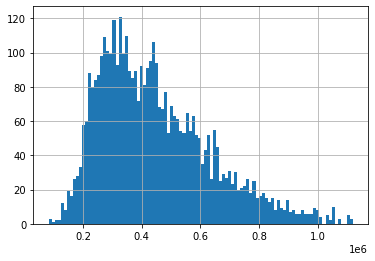

In [23]:
#check the distribution of price in test data
y_test.hist(bins = 100)
y_test.mean()

"""
This means that for an average house price, this algorithm will be off by about $130331 thousands. Given that the mean value of house price is 445683, the algorithm can patially set the price. However, we still want to have a human double-check and adjust these prices rather than just allowing the algorithm to set them.
"""

The coefficients of the selected features shows that the sqft_living is the most important features which affected the house price since the sqft_living is normally more than 1000. The affection of features sqft_lot and sqft_basement are very small even they are negtive numbers.  The affection of grade on the house is very big also. Also, if the house is renovated within 10 years, the price will increased 46690 dollars. If there is waterfront of the house, the price of the house will increase dramtically with 140605.

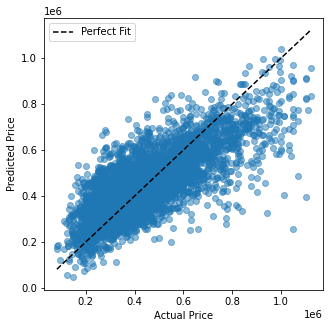

In [24]:
# For the validation, I first plot the scatter plot of Predicted Price vs the Actual Price
preds = final_model.predict(X_test_final)
fig, ax = plt.subplots(figsize =(5,5))

perfect_line = np.arange(y_test.min(), y_test.max())
#perfect_x = [0, 1]
#perfect_y = [0, 1]

#ax.plot(perfect_x, perfect_y, linestyle="--", color="black", label="Perfect Fit")
ax.plot(perfect_line,perfect_line, linestyle="--", color="black", label="Perfect Fit")
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

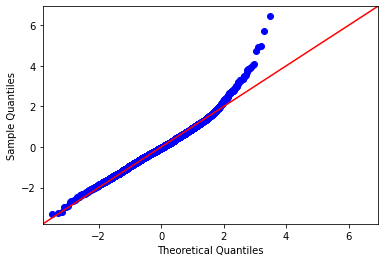

In [25]:
# test the data by normal distribution
import scipy.stats as stats
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

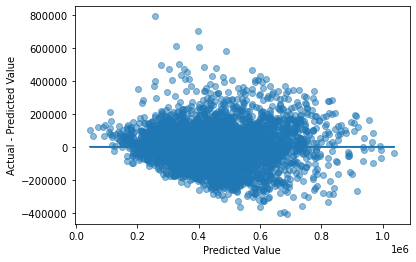

In [26]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

The validation of prediction and real data shows that the prediction price for most house whose price is low (20% of the max price) is close to the real price.  qqplot showes that the house price is well predicted when the house price is not very high. However, for the high value price house, the prediction is not very acturate. There is a lot of shift of prediction price when the house value increase especialy when house price is more than 2 million. 

# Summary
The Coefficient of all the features show how each of the feature affect the house price. Briefly, for the house size, the sqft_living had value 114.5637 which suggests that increasing 1 sqrt of living area, the house pirce will increase 114 dollars. However, the sqft_lot and sqft_basement had negtive correlation to the house price even though the correlation value is very low compared to sqft_living. The number is bedrooms had negtive negtive correlation to the house price. More bathrooms, floors, views and conditions will increase the house price in general. Grade 4-7 decrease the house price and Grade 8-10 increase the house price a lot by around 500000 each level. To the zipcode, the house in some area is much higer than others. The house price in month March to July is obviously higher than other months. If there is what front, the house price will increase by 128000. If the house is renovated, the house price can increase around 7540. If the renovated is within 10 years, the house price can increase around 51400.

To the buyer, We had our prediction model which can predict the house price and give buyer some suggestion about the price they want. However, the predicted house price is higher than the selling price when the price is over 700000. To the seller, our model give them some suggestion how to increase the potential selling value. For example, they can try to renovate the house and make waterfront if possible and increase the grade of the house.
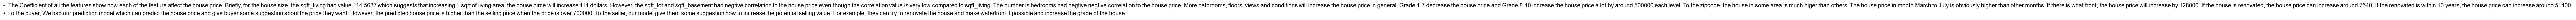
